<img src="AW&H2015.png" style="float: left">

<img src="flopylogo.png" style="float: center">

# Evaluating what happens when using Parameter Estimation on 2 parameters:  Plotting the objective function response surface

Pages 400-401 of Anderson et al. (2015) start setting out the approach for how parameter estimation finds a best fit.  It does it by distilling all the metrics of fit into a single number, which then it minimizes.  This single number is called the "measurement objective function", often given the symbol Phi, and reflects the residual between the observed and simulated value.  Because residuals can be positive or negative, we square them to make sure the residuals are positive and do not offset each other.  Finally, we typically hold fitting some observations to be higher priority than others; we express this using weights to emphasize or de-emphasize a residual.  Here is the equation for our cross-section xsec model, where we only have heads as observations:

<img src="SOSWR_eq_AW&H2015.png" style="float: center">

where Phi is the "sum of squared weighted residuals" that we look to minimize, *whi* is the weight for the ith head observation; *hm* is the measured (observed) head target; *hs* is the simulated head; and n is the number of observations.  

We can calculate Phi using model output for a range of two parameters that affect calibration. The plot of two parameters and the resulting Phi is called a response surface. This response surface is like a topographic contour map because it shows three dimensions in two dimensions.  Here is an idealized plot taken from figure 9.10a in Anderson et al. (2015):

<img src="Fig9.10a_idealized_obj_fxn.png" style="float: center">
 

In this notebook we will investigate what the objective function looks like for the model we used in the xsec_k_and_flux notebook.  

We also will use a PEST++ utility called "sweep" that moves your single run to multiple simultaneous runs via parallel processing on your laptop! 

Recall that the cross section looked like:

<img src="xsect_figure.png" style="float: center">

We had 2 parameters, the horizontal hydraulic conductivity of the aquifer and the flux at the rightmost boundary condition.  So, let's run a range of these parameter values and plot the resulting objective function. 

In [1]:
%matplotlib inline
import os
import shutil
import subprocess as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu
import platform

if 'window' not in platform.platform().lower():
    pref = './'
    pestchek = './pestchek'
else:
    pref = ''
    pestchek = 'pestchek'

setting random seed


(this "setting random seed" is so that the code pyemu can reproduce random operations like Monte Carlo - pretty slick for a model archive!)

Next block will copy the model files over

In [2]:
base_dir = os.path.join("..","..","models","10par_xsec","complete_pest_setup")
[shutil.copy2(os.path.join(base_dir,f),f) for f in os.listdir(base_dir)]
if not os.path.exists('base_xsec_dir'):
    os.mkdir('base_xsec_dir')
[shutil.copy2(os.path.join(base_dir,cf),os.path.join('base_xsec_dir',cf)) for cf in os.listdir(base_dir)];


In order to plot an objective function like we saw above, we have to sample the range of K and flux parameter values.  In the code below for K we sample from 0.1 to 4.0 and divding it up into 50 equal parts; for the boundary flux we sample from 0.1 to 2.5 in 50 equal parts.  Then we write a csv file of these parameter values to run in PEST++ (with **NOPTMAX=0** so that it only runs once and reports the objective function)

In [3]:
nsamples = 50
hk_values = np.linspace(0.1,4.0,nsamples)
fx_values = np.linspace(.1,2.5,nsamples)
c = 0
with open("grid.csv",'w') as f:
    f.write("run_id,hk1,cal_flux,fore_flux\n")
    for v1 in hk_values:
        for v2 in fx_values:
            f.write("{0:d},{1:15.6E},{2:15.6E},1.0\n".format(c,v1,v2))
            c += 1
shutil.copy2('grid.csv',os.path.join('base_xsec_dir','grid.csv'))

'base_xsec_dir/grid.csv'

### Being this takes a while to run, let's make sure NOPTMAX=0 before we launch.  You can do it in a separate terminal or excute the next block of code and look in the terminal window where you launched this notebook. 

In [4]:
os.system("{0} k_wel.pst".format(pestchek))

0

Here's where we define what the plot of objective function response surface looks like (we haven't run the forward model yet so there's no output)

In [5]:
def resp_plot():
    df_in = pd.read_csv("grid.csv")
    df_out = pd.read_csv("sweep_out.csv")
    resp_surf = np.zeros((nsamples,nsamples))
    c = 0
    for i,v1 in enumerate(hk_values):
        for j,v2 in enumerate(fx_values):
            resp_surf[j,i] = df_out.loc[c,"phi"]
            c += 1
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    X,Y = np.meshgrid(hk_values,fx_values)
    resp_surf = np.ma.masked_where(resp_surf>5,resp_surf)
    p = ax.pcolor(X,Y,resp_surf,alpha=0.5, cmap="spectral")
    plt.colorbar(p)
    c = ax.contour(X,Y,resp_surf,levels=[0.1,0.2,0.5,1,2,5],colors='k')
    plt.clabel(c)
    ax.set_xlim(hk_values.min(),hk_values.max())
    ax.set_ylim(fx_values.min(),fx_values.max())
    ax.set_xlabel("hk1 ($\\frac{L}{T}$)")
    ax.set_ylabel("cal_flux ($\\frac{L^3}{T}$)")


## Now let's burn some silcon - this next line will fire up your CPUs and create 20 workers to run our xsec model 2,500 times (50 x 50).  We are using a PEST++ utility "Sweep", which creates worker directories, manages the runs, then cleans up the worker directories when finished. You should watch the progress in your terminal window where this notebook was launched.

# THIS WILL TAKE SOME TIME - DO NOT ADVANCE THROUGH UNTIL YOU SEE "SWEEP COMPLETE" IN YOUR TERMINAL

In [6]:
pyemu.utils.start_slaves('base_xsec_dir',"{0}sweep".format(pref),"k_wel.pst",20,slave_root='.',port=4004,master_dir='.')

## WHEN SWEEP IS DONE (you did see "Sweep Complete..." in your terminal?) then advance to the next block

### Here is a plot of the response surface with just the heads to constrain the data (this too takes a little time to render so don't fly through it to the next code block)

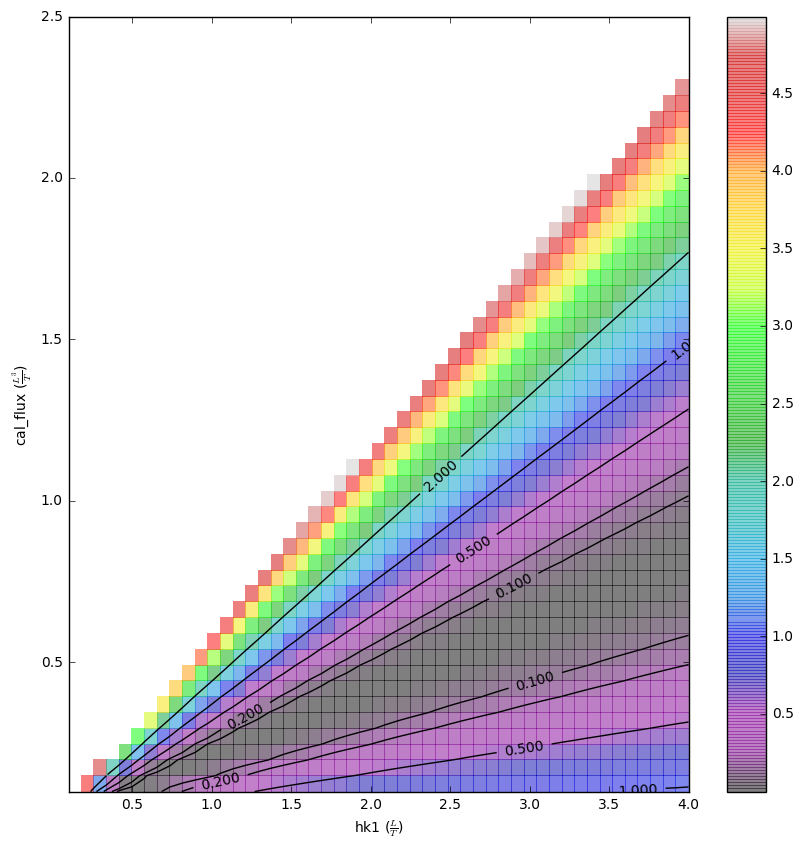

In [7]:
resp_plot()

## This plot is a "contour map" of the objective function, which equals the degree of fit to our observations.  The low area less than 0.1 is a trough, which means that there are a number of combinations of horizontal hydraulic conductivity and boudary flux that will give the same fit.

## But say we have experience that says the boundary flux should be around 0.5 cubic meters per day - we can tell PEST this.  You can see we supplied it to PEST as "prior information" near the bottom of k_wel_reg.pst.  The result is as the boundary flux parameter moves away from 0.5 it penalizes our fit. 

Here's that part of the PEST control file from SIR 2010-5169:

<img src="SIR2010-5169_prior_information_section.png" style="float: center">

Remember the variable definitions are also provided for you in Appendix 1 of SIR 2010-5169

### Again, because this takes a while to run, let's make sure NOPTMAX=0 in this new file (k_wel_reg.pst)  before we launch.  You can do it in a separate terminal or excute the next block of code and look in the terminal window where you launched this notebook.

In [7]:
os.system("{0} k_wel_reg.pst".format(pestchek))

0

## Now let's burn some silcon - this next line will fire up your CPUs and run our xsec model 2,500 times (50 x 50).  It is setup to run 500 runs 5 times - you can watch the progress in your terminal window where this notebook was launched.

# THIS WILL AGAIN TAKE SOME TIME - DO NOT ADVANCE THROUGH UNTIL YOU SEE "SWEEP COMPLETE" IN YOUR TERMINAL

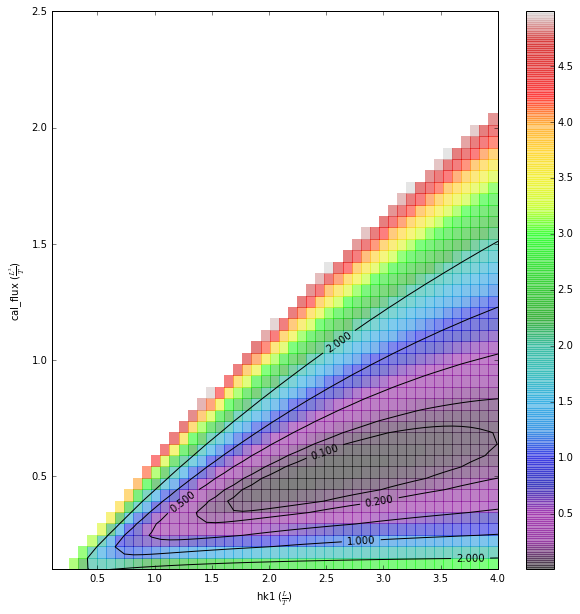

In [7]:
pyemu.utils.start_slaves('base_xsec_dir',"{0}sweep".format(pref),"k_wel_reg.pst",20,slave_root='.',port=4004,master_dir='.')
resp_plot()

## Now the trough is becoming a enclosed depression.  This means that there are fewer combinations of hk1 and the cal_flux boundary condition that will provide a good fit.  Notice that the enclosed depression is centered on our priori information value of 0.5 cubic meters per day.

### How strongly the prior information penalizes our fit depends on the weight we give it.  In the run above it was given a weight of 2.0.  Now we'll increase the weight to 10, which means we'll penalize the fit more as we move away from 0.5.

# Your Turn!
### Copy over `k_wel_reg.pst` to `k_wel_reg_1.pst`, increase the prior information weight to 10.

### Then run `pestchek` and set it loose using `pyemu` in the block below.

# We'll re-run one last time, and again, THIS WILL AGAIN TAKE SOME TIME - DO NOT ADVANCE THROUGH UNTIL YOU SEE "SWEEP COMPLETE" IN YOUR TERMINAL

In [ ]:

pyemu.utils.start_slaves('base_xsec_dir',"{0}sweep".format(pref),"k_wel_reg_1.pst",20,slave_root='.',port=4004,master_dir='.')

In [ ]:
resp_plot()

# Parting thought:  In general we don't see this type of response surface for an applied model because they typically have more than two parameters!  

# Advanced:

## These Python notebooks give you new flexibility that you can take advantage of after you leave.  Rather than having you mess with the code itself,  we typically define a variable that you can use to explore these concepts.  Here, change the *pst.prior_information.weight* variable in the 2nd line in the code block above to something between 2 and 10 and re-run the block.  Does your plot look like an intermediary between the end members shown above?  In the notebooks that follow, look for these types of variables and experiment - we'll give you complete notebooks you can revert back to in case things break.